# <p><center> **PROYECTO 15** </center></p>  


La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import root_mean_squared_error

## Lectura y procesamiento.

En éste capítulo haremos lectura, adaptación procesamiento para poder entrenar modelos predictivos.

### Primera lectura.

In [2]:
data = pd.read_csv("taxi.csv", index_col="datetime", parse_dates=[0])
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


No se ve nada raro en cuanto a las estructuras, nuestros datos necesitan estar un un muestreo de 1 hora, haremos el remuestreo y sumaremos todos los taxis pedidos dentro de esa hora.

### Remuestreo.  

In [3]:
data = data.resample("1h").sum()
data.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


El remuestreo se realizó sin contratiempos.

### Primer análisis.  

Usaremos la funcón *seasonal_decompose()* la cuál nos descompone nuestros datos en tendencia, estacionalidad y residuos.

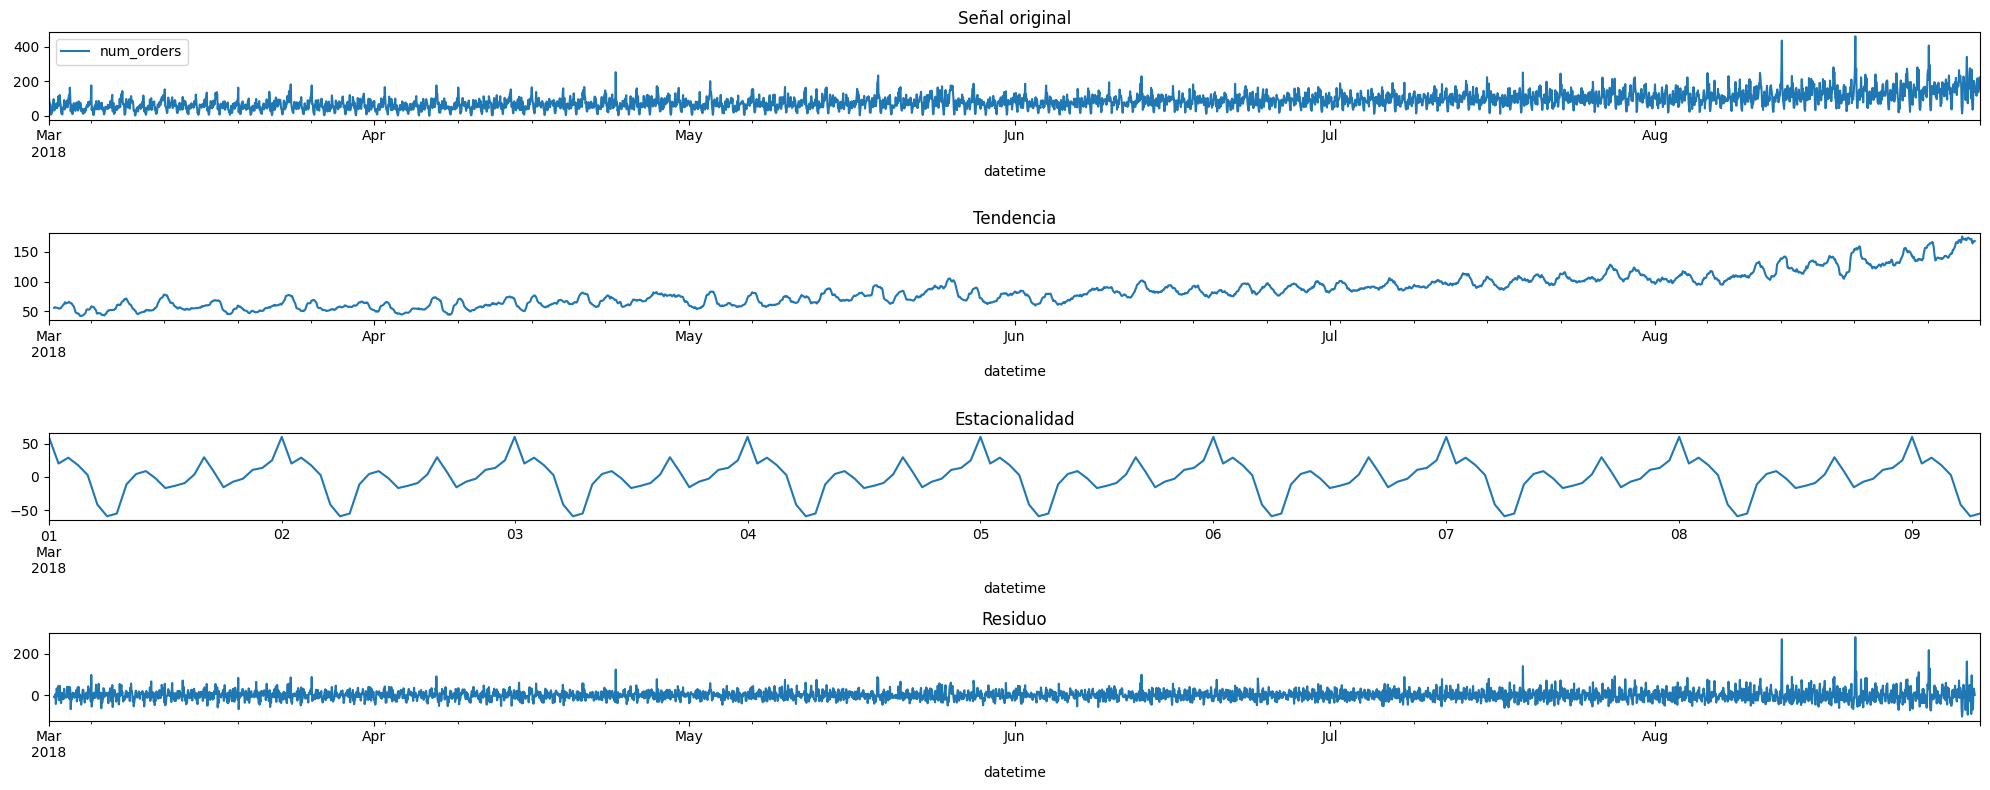

In [4]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(20, 8))

plt.subplot(411)
data.plot(ax=plt.gca())
plt.title("Señal original")

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(413)
decomposed.seasonal.iloc[0:200].plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuo')

plt.tight_layout()

Analicemos los 4 componentes:  

* **Datos originales:** Observamos la primera gráfica, parece tener un comportamiento muy estable en los primeros meses, mientras que los últimos meses tiene un comportamiento mas caótico (mayor entropía), debido probablemente a que es temporada vacacional del 2018. Veremos las siguientes gráficas para ver mejor el comportamiento.  

* **Tendencia:** Observamos la segunda gráfica, podemos ver una tendencia que sube conforme los meses pasan, esto debido a que entramos a la época vacacional y probablemente a que en los meses con mayor calor la gente suele salir mas. También vemos pequeñas protuberancias que coinciden con días de la semana específicos que corresponden a lunes y sábado.  

* **Estacionalidad:** Observamos la tercera gráfica. Podemos ver aquí el cpomportamiento diario que contiene nuestros datos, podemos ver un ciclo que se establece a lo largo del día teniendo el mayor número de pedidos a media noche y el menor número alrededor de las 4am.  

* **Residuo:** Observamos la cuarta gráfica. Estos son los datos que no se pueden explicar tan sencillamente, como los picos a medidados del mes de agosto que puedan ser tanto fechas vacionales como fechas de celebración en la ciudad, el punto de esta gráfica es que se le retiró tanto la tendencia como la estacionalidad dejando a fin de no encontrar mejor palabra, ruido.  

## Creación de modelo con  búsqueda de hiperparámetros óptimos.  

Para entrenar este modelo haremos una función que pueda generar nuestras caracterísicas. El por qué hacemos esto es que estos serán hiperparámetros que se llevarán para buscar el modelo óptimo, el primer hiperparámetro, max_lag, es un *trade of* entre complejidad del modelo y presicición, mientras que el segundo hiperparámetro, rolling_mean_size, se trata de buscar el tamaño ópticmo que pueda mejorar la predicción.

### Función extractora de características.

In [5]:
# Nuestra función creadora de características
def make_features(data, max_lag, rolling_mean_size):
    
    col_name = data.columns[0]

    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[col_name].shift(lag)

    data['rolling_mean'] = data[col_name].shift().rolling(rolling_mean_size).mean()

### Búsqueda de modelo con hiperparámetros óptimos.

In [6]:



## Calculamos nuestros hiperparámetros
lag_range = np.array(range(1,90))
mean_size_range = np.array(range(1,100))

lag_vector = []
mean_size_vector = []
train_rmse = []
test_rmse = []
iteration = 0
# Creamos y evaluamos modelos
col_name = data.columns[0]

for lag in lag_range:
    for mean_size in mean_size_range:
        iteration += 1

        data2 = data.copy()
        make_features(data2, lag, mean_size)

        train, test = train_test_split(data2, shuffle=False, test_size=0.2)
        train = train.dropna()

        X_train = train.drop(columns=col_name, axis=1)
        y_train = train[col_name]
        X_test = test.drop(columns=col_name, axis=1)
        y_test = test[col_name]

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_rmse.append(root_mean_squared_error(y_train, y_pred_train))
        test_rmse.append(root_mean_squared_error(y_test, y_pred_test))
        lag_vector.append(lag)
        mean_size_vector.append(mean_size)

        if iteration % 1000 == 0:
            print(f"iteration {iteration}, max_lag: {lag}, mean_size: {mean_size}, test_rmse: {test_rmse[-1]}.")
            

        


iteration 1000, max_lag: 11, mean_size: 10, test_rmse: 47.435345727397284.
iteration 2000, max_lag: 21, mean_size: 20, test_rmse: 48.194676749127225.
iteration 3000, max_lag: 31, mean_size: 30, test_rmse: 41.85014450146476.
iteration 4000, max_lag: 41, mean_size: 40, test_rmse: 42.71857809876488.
iteration 5000, max_lag: 51, mean_size: 50, test_rmse: 38.47491431467403.
iteration 6000, max_lag: 61, mean_size: 60, test_rmse: 38.93076459280924.
iteration 7000, max_lag: 71, mean_size: 70, test_rmse: 38.88825833944725.
iteration 8000, max_lag: 81, mean_size: 80, test_rmse: 38.059039044412785.


In [7]:
linear_regression_data = pd.DataFrame(dict(
    max_lag = lag_vector,
    mean_size = mean_size_vector,
    train_rmse = train_rmse,
    test_rmse = test_rmse

))
linear_regression_data.sort_values(by="test_rmse").head(5)

,max_lag,mean_size,train_rmse,test_rmse
8807,89,96,21.342438,37.608529
8708,88,96,21.350430,37.649162
8609,87,96,21.350993,37.657733
8510,86,96,21.360868,37.658182
8411,85,96,21.361465,37.666050


Mostramos en un DataFrame los 5 mejores desempeños utilizando la raíz del error cuadrático medio (RMSE). las mejores características fueron utilizando una média móvil de 96 puntos y 89 columnas con datos recorridos (lag). Es interesane que el número de columnas necesarios para poder predecir correctamente se aproxima a 3 meses, mientras que el tamaño de la media móvil tambien se aproxima a 3 meses.  
  
Podemos sugerir que mantener datos de los últimos 3 meses es necesario para hacer una predicción correcta.

###  Entrenamiento de modelo final.  

Los hiperparámetros óptimos se usarán para entrenar un modelo final y se graficarán sus predicción y errores.

In [8]:
lag = 89
mean_size = 96

make_features(data, lag, mean_size)

train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()

X_train = train.drop(columns=col_name, axis=1)
y_train = train[col_name]
X_test = test.drop(columns=col_name, axis=1)
y_test = test[col_name]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = root_mean_squared_error(y_train, y_pred_train)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

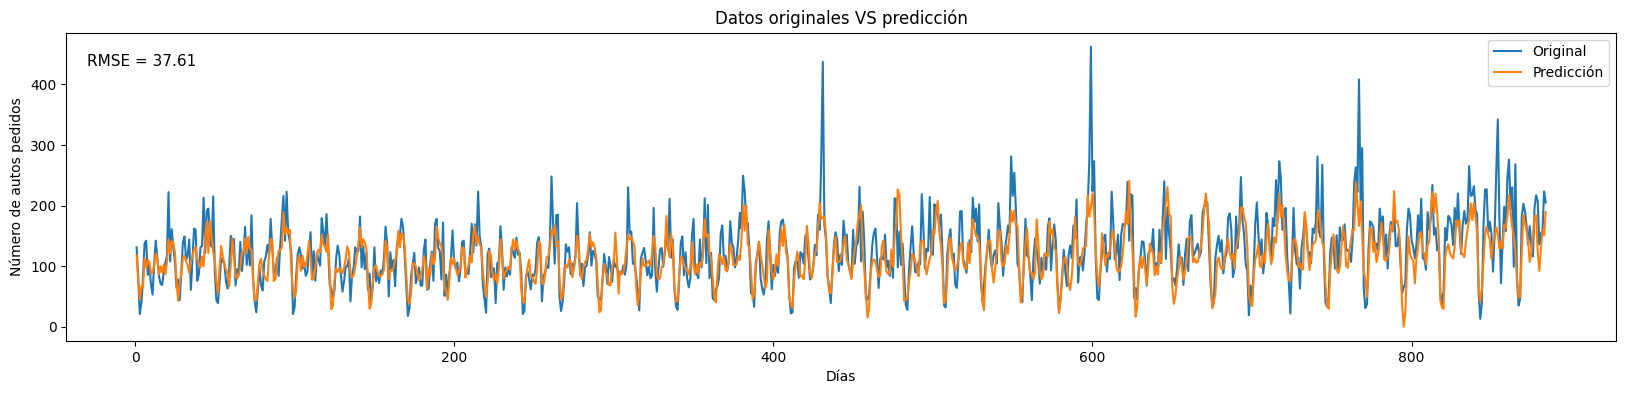

In [9]:
x = np.array(range(1, y_test.shape[0]+1))

plt.figure(figsize=[20, 4])
plt.plot(x, y_test)
plt.plot(x, y_pred_test)
plt.legend(["Original", "Predicción"])
plt.title("Datos originales VS predicción")
plt.ylabel("Número de autos pedidos")
plt.xlabel("Días")
plt.text(-30, 430, f"RMSE = {test_rmse:.2f}", fontsize=11)
plt.show()

## Conclusión.  

Este proyecto se divide en 2 grandes bloques:  

* **Lectura y procesamiento.** Esta etapa agrupa varias acciones en los datos como:
    * *Primera lectura:* No se encontró nada extraño en los datos, ni nulos ni duplicados por lo que no se realizaron acciones.  
    * *Remuestreo:* Se usa el remuestreo de 1 hora para poder trabajar de mejor forma con los datos.
    * *Primer análisis:* Se explican los comportamientos de tendencia, estacionalidad y residuos en nuestros datos.

* **Creación de modelos con búsqueda de hiperparámetros.** Esta etapa busca y entrena el mejor modelo para predecir el comportamiento.  
    * *Función extractora de características.* Creamos una función que nos ayuda a buscar el mejor modelo teniendo como hiperparámetros el número de columnas y el tamaño de una media móvil.
    * *Búsqueda de modelo óptimo.* Usamos la función anterior para hacer una búsqueda de modelos, se muestran los 5 mejores modelos creados.  
    * *Entrenamiento del modelo final.* Usamos los hiperparámetros óptimos para entrenar un modelo final teniendo como RMSE de 37.61. Se grafican los datos originales vs los graficos predichos.

Se realizó una predicción muy aceptable teniendo solo errores en aquellas fechas con pedidos anormales, recordemos que en los residuos teníamos exactamente aquellos comportamientos anormales. poder entender las fechas de celebración, épocas de vacaciones nos puede ayudar a tener una mayor predicción en los pedidos.